In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import os

You should consider upgrading via the 'd:\new folder\python.exe -m pip install --upgrade pip' command.


In [2]:
tatmot=yf.Ticker("TATAMOTORS.NS")
tatmot=tatmot.history(period="max")
tatmot.to_csv("tatmot.csv")

In [3]:
tatmot

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1995-12-25,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-26,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-27,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-28,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-29,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-02,423.049988,425.100006,420.149994,422.149994,12433578,0.0,0.0
2022-11-03,419.399994,423.299988,414.500000,416.250000,10987519,0.0,0.0
2022-11-04,418.200012,426.000000,416.899994,425.350006,12277023,0.0,0.0


<AxesSubplot:xlabel='Date'>

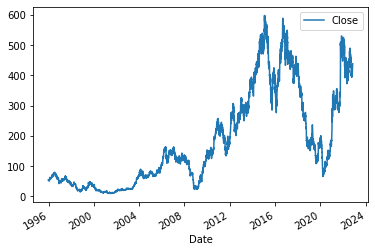

In [4]:
tatmot.plot.line(y='Close',use_index=True)

In [5]:
del tatmot["Dividends"]
del tatmot["Stock Splits"]

In [6]:
tatmot["Tomorrow"] = tatmot["Close"].shift(-1)
tatmot["Target"] = (tatmot["Tomorrow"] > tatmot["Close"]).astype(int)


In [7]:
tatmot

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1995-12-25,53.472778,53.472778,53.472778,53.472778,0,53.472778,0
1995-12-26,53.472778,53.472778,53.472778,53.472778,0,53.472778,0
1995-12-27,53.472778,53.472778,53.472778,53.472778,0,53.472778,0
1995-12-28,53.472778,53.472778,53.472778,53.472778,0,53.472778,0
1995-12-29,53.472778,53.472778,53.472778,53.472778,0,53.472778,0
...,...,...,...,...,...,...,...
2022-11-02,423.049988,425.100006,420.149994,422.149994,12433578,416.250000,0
2022-11-03,419.399994,423.299988,414.500000,416.250000,10987519,425.350006,1
2022-11-04,418.200012,426.000000,416.899994,425.350006,12277023,435.000000,1


In [8]:
!pip install sklearn
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = tatmot.iloc[:-100]
test = tatmot.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

You should consider upgrading via the 'd:\new folder\python.exe -m pip install --upgrade pip' command.


RandomForestClassifier(min_samples_split=100, random_state=1)

In [9]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.48936170212765956

<AxesSubplot:xlabel='Date'>

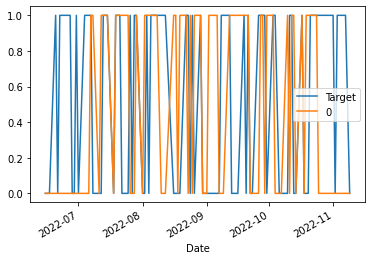

In [10]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [11]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    return combined

In [12]:
def backtest(data, model, predictors, start=750, step=80):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [13]:
predictions = backtest(tatmot, model, predictors)

In [14]:
predictions.value_counts()

Target  0
1       0    2280
0       1    1824
        0    1748
1       1    1748
dtype: int64

In [15]:
precision_score(predictions["Target"],predictions[0])

0.48936170212765956

In [16]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.53
0    0.47
Name: Target, dtype: float64

In [17]:
horizons = [2,5,60]
new_predictors = []

for horizon in horizons:
    rolling_averages = tatmot.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    tatmot[ratio_column] = tatmot["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    tatmot[trend_column] = tatmot.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [18]:
tatmot=tatmot.dropna()

In [19]:
tatmot

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60
Date,,,,,,,,,,,,,
1996-03-18,58.721548,59.017058,58.397897,59.010021,224129,58.447144,0,1.002450,1.0,1.001648,3.0,1.054836,26.0
1996-03-19,59.010017,58.679330,58.123498,58.447144,113238,58.447144,0,0.995208,1.0,0.992710,2.0,1.043228,26.0
1996-03-20,58.447144,58.447144,58.447144,58.447144,0,59.382927,1,1.000000,0.0,0.995709,1.0,1.041687,26.0
1996-03-21,58.447152,59.397000,58.714521,59.382927,132546,59.396984,1,1.007942,1.0,1.009884,2.0,1.056510,27.0
1996-03-22,59.382911,59.523632,59.101474,59.396984,127067,60.009117,1,1.000118,2.0,1.007807,3.0,1.054907,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,414.899994,422.399994,412.799988,421.350006,17324893,422.149994,1,1.010311,2.0,1.024559,5.0,0.969131,30.0
2022-11-02,423.049988,425.100006,420.149994,422.149994,12433578,416.250000,0,1.000948,2.0,1.017793,5.0,0.972673,31.0
2022-11-03,419.399994,423.299988,414.500000,416.250000,10987519,425.350006,1,0.992963,1.0,0.999448,4.0,0.961022,30.0


In [20]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [21]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [22]:
predictions = backtest(tatmot, model, new_predictors)
predictions.value_counts()

Target  Predictions
0       0.0            2808
1       0.0            2759
        1.0             207
0       1.0             176
dtype: int64

In [23]:
predictions["Predictions"].value_counts()

0.0    5567
1.0     383
Name: Predictions, dtype: int64

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5404699738903395

In [25]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.501513
1    0.498487
Name: Target, dtype: float64

In [26]:
tatmot

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60
Date,,,,,,,,,,,,,
1996-03-18,58.721548,59.017058,58.397897,59.010021,224129,58.447144,0,1.002450,1.0,1.001648,3.0,1.054836,26.0
1996-03-19,59.010017,58.679330,58.123498,58.447144,113238,58.447144,0,0.995208,1.0,0.992710,2.0,1.043228,26.0
1996-03-20,58.447144,58.447144,58.447144,58.447144,0,59.382927,1,1.000000,0.0,0.995709,1.0,1.041687,26.0
1996-03-21,58.447152,59.397000,58.714521,59.382927,132546,59.396984,1,1.007942,1.0,1.009884,2.0,1.056510,27.0
1996-03-22,59.382911,59.523632,59.101474,59.396984,127067,60.009117,1,1.000118,2.0,1.007807,3.0,1.054907,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,414.899994,422.399994,412.799988,421.350006,17324893,422.149994,1,1.010311,2.0,1.024559,5.0,0.969131,30.0
2022-11-02,423.049988,425.100006,420.149994,422.149994,12433578,416.250000,0,1.000948,2.0,1.017793,5.0,0.972673,31.0
2022-11-03,419.399994,423.299988,414.500000,416.250000,10987519,425.350006,1,0.992963,1.0,0.999448,4.0,0.961022,30.0
